# Lecture 9: Shooting, Matching and finite difference

**Overview:**
* Time independent Schrödinger eqn.
* Finite difference formula (discrete Laplacian).

**Next Lecture:**
* Boundary value problems, Laplace and Poisson equations.
---

## Tasks
### Shooting:
- How does the number of bound states in the square well change when you change the depth of the well? What about changing the width of the well? Do your finding agree with your expectations?

- Is it possible to find a minimum well depth above which there is no bound-state?

### Finite Difference
- Modify the code to include a simple harmonic potential i.e $V= 1/2 kx^2$.
- Compare the accuracy of the shooting and finite difference methods for a simple harmonic potential. How do your results compare with the exact eigen energies?
- Try defining some other interesting potentials e.g. double square well.

In [43]:

import numpy as np
from scipy.integrate import odeint
import rootfinder as rtf
import matplotlib.pyplot as plt
from scipy.linalg import eigh

In [44]:
class QM(object):
    def __init__(self,E, npoints, x_start, x_end = 0, u0 = 0.0, v0 = 0.01 ):
        self.E = E
        self.npoints = npoints
        self.uv0 = np.array([u0, v0]) # NumPy array with initial position and velocity
       
        # always want to start at furthest point and go to zero
        self.xarray = np.linspace(x_start, x_end, npoints, endpoint = True) # include final timepoint

    def scipy_trajectory(self):
        """calculate trajectory using SciPy ode integrator"""
        self.uv = odeint(self.sch, self.uv0, self.xarray)
        self.uv_end = self.uv[-1]


    def sch(self, uv, x):
    
        """right hand side of the differential equation"""
        V0 = 50.0
        a = 10*10**(-11)
        m = 9.1*10**(-31)
        h = 6.582119*10**(-16)
#         zeta = x*V0*a*m/h**2
#         xz = x*h**2/(V0*a*m)
        u = uv[1]
        v = (2/(V0*a) )*(self.Potential(x) - self.E)*uv[0]
        return np.ravel(np.array([u, v]))

    def Potential(self, x):
        # harmonic potential..v0 in eV units
        V0 = 50.0
        a =10*10**(-11)
#         m = 9.1*10**(-31)
#         h = 6.582119*10**(-16)        
#         zeta = x*V0*a*m/h**2
#         xz = x*h**2/(V0*a*m)
        Vx = V0*(x)**2/(a**2)
        return Vx

In [45]:
# the matching function
def match(En):
    a = 1.0e-11
    V0 = 50.0
    a =10*10**(-11)
    m = 9.1*10**(-31)
    h = 6.582119*10**(-16)
    aZeta = a*h**2/(V0*a*m)   # aZeta = a*1/zeta
#     zetaA = a*V0*a*m/h**2
    p_up = QM(E = En, npoints = 1000, x_start = -10*aZeta)
    p_down = QM(E = En, npoints = 1000, x_start = 10*aZeta)
    p_up.scipy_trajectory()
    p_down.scipy_trajectory()
#     print(p_down.uv_end[0])

    return p_down.uv_end[0]*p_up.uv_end[1] - p_down.uv_end[1]*p_up.uv_end[0]

No bracket, increasing energy to 110
No bracket, increasing energy to 120
No bracket, increasing energy to 130
No bracket, increasing energy to 140
No bracket, increasing energy to 150
No bracket, increasing energy to 160
No bracket, increasing energy to 170
No bracket, increasing energy to 180
No bracket, increasing energy to 190


NameError: name 'xa' is not defined

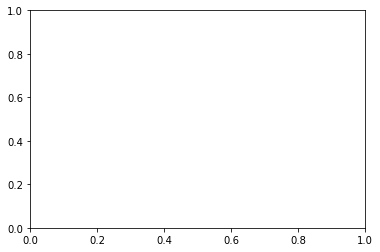

In [42]:
# a = 1.0e-3
E1 =  100 # start Energy search from 100 to 200 eV
dE = 10
npoints = 1000


E_SM = []

fig = plt.figure()
ax = fig.add_subplot(111)

# Bound states must have E < 0 for the square well. 
# Cut off after we have found a few states
while (E1 < 200-dE):

    if match(E1)*match(E1 + dE) < 0 :  # bracket E
        # find the energy
        E = rtf.bisect(match, E1, E1+dE, 1e-12)
        print('Energy found: %.5f'%(E))
        E_SM.append(E)
        
        dx = 16*a/npoints
        
        # for plotting, must ensure overlap of left and right solutions 
        p_up = QM(E, npoints = npoints+4, x_start = -10*aZeta, x_end = 0+4*dx)
        p_down = QM(E, npoints = npoints-4, x_start = 10*aZeta, x_end = 0+4*dx)
        
        p_up.scipy_trajectory()
        p_down.scipy_trajectory()
        
        # scale factor
        scale = p_up.uv_end[0]/p_down.uv_end[0]
        
        # full solution, combine up and down solutions
        psi_x = np.concatenate((p_up.uv[:-1,0], scale*p_down.uv[::-1,0]))
        xa = np.linspace(-10,10, 2*npoints-1, endpoint = True)
        
        # plot the scaled solution (not normalized), scale maximum to 1 for plotting purposes
        ax.plot(xa, psi_x/max(psi_x))
    else : 
        print("No bracket, increasing energy to", E1+dE)
        
    E1 += dE

# Solution is exact only for for wide and deep well, and odd n 
# a = 5
# V0 = 10
# n = np.arange(1,5,2)
# Exact = -V0+np.pi**2/2/a**2*n**2
# print(Exact)

# plot the potential

ax.plot(xa, np.vectorize(p_up.Potential)(xa)/10., color = 'k', lw =2)
ax.set_xlim([-6, 6])
ax.set_xlabel('x')
ax.set_ylabel('$\psi$')
plt.show()

## Finite difference

In [ ]:
def potential(x):
    """ The potential energy for a finite square well"""
    a = 5
    V0 = 10
    V = np.zeros(x.shape)
    V[np.nonzero(np.abs(x)<a/2)] = -V0   
    return V    

In [ ]:
N = 2000  # number of lattice points including boundaries at 0, N-1
L = 100.0 
dx = L / N # x runs from -L/2 + dx/2 to L/2 + dx/2

# D = array(zeros((N, N))) # discrete laplacian operator
D = np.diag([-2]*(N))
D+= np.diag([1]*(N-1),1) + np.diag([1]*(N-1),-1) 
print("\nLattice Laplacian operator")
print(D)
        
x = np.linspace(0.5*(dx-L), 0.5*(L-dx), N)        
V = np.diag(potential(x)) # potential (the potential is a diagonal matrix because it's a one dimensional problem; see below
    
H = -0.5 * pow(dx, -2.0) * D + V # Hamiltonian.  Here m = hbar = 1
        
print("\nMatrix elements of Hamiltionian = ")
print(H)

In [ ]:
E_FD, v = eigh(H) # diagonalize Hamiltonian

# eigh returns the array of shape (N,N) where each column is an eigenvector; we transpose for plotting later
v = v.transpose() 
print("\nGround state energy = ", E_FD[0])
print("Energies of low-lying excited states = ", E_FD[1], E_FD[2], E_FD[3], E_FD[4])

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
#plot potential (scaled)
ax.plot(x, potential(x)/np.max(np.abs(potential(x))), lw = 2, color = 'grey')


ax.plot(x, v[0]/np.max(v[0]))
ax.plot(x, v[1]/np.max(v[1]))
ax.plot(x, v[2]/np.max(v[2]))

ax.set_xlabel("x")
ax.set_ylabel("$\psi$")

ax.set_xlim([-6,6])
#ax.set_ylim([-1, 1])

In [ ]:
# Comparision of Shooting and Matching with Finite Difference:
print("\nGround state energy")
print("Matching: \t\t", E_SM[0], "\nFinite Difference:\t", E_FD[0])

print("\nFirst excite state energy")
print("Matching: \t\t", E_SM[1], "\nFinite Difference:\t", E_FD[1])

print("\n2nd excited state energy")
print("Matching: \t\t", E_SM[2], "\nFinite Difference:\t", E_FD[2])